# Fatty-acid-concentration

## Seperate Fatty acid chain length for different lipid classes

In [ ]:
# Load necessary libraries
library(readxl)
library(dplyr)
library(tidyr)
library(ggplot2)
library(openxlsx)
library(purrr)
library(forcats)

# Step 1: Loading and Summarizing Data
# Load the data from the Excel file
file_path <- "fatty-acid-concentration.xlsx"
sheet1 <- read_excel(file_path, sheet = "Sheet1")
sheet2 <- read_excel(file_path, sheet = "Sheet2")

# Select relevant columns from Sheet2 for merging
sheet2_selected <- sheet2 %>% select(GlobalID, FAKey, FAGroupKey)

# Merge the selected columns from Sheet2 to Sheet1
sheet1_merged <- sheet1 %>% left_join(sheet2_selected, by = "GlobalID")

# Step 2: Splitting and Cleaning FAKey Parts
# Split the FAKey column wherever an underscore '_' appears
sheet1_merged <- sheet1_merged %>%
  mutate(FAKey_Split = strsplit(as.character(FAKey), "_")) %>%
  mutate(FAKey_Part1 = sapply(FAKey_Split, "[", 1),
         FAKey_Part2 = sapply(FAKey_Split, "[", 2),
         FAKey_Part3 = sapply(FAKey_Split, "[", 3),
         FAKey_Part4 = sapply(FAKey_Split, "[", 4))

# Clean the FAKey parts by removing '(', ')', and anything after '+'
clean_fa_key_part <- function(part) {
  if (!is.na(part)) {
    part <- sub("\\+.*", "", part)  # Remove anything after '+'
    part <- gsub("[()]", "", part)  # Remove '(' and ')'
  }
  return(part)
}

sheet1_merged <- sheet1_merged %>%
  mutate(FAKey_Part1 = sapply(FAKey_Part1, clean_fa_key_part),
         FAKey_Part2 = sapply(FAKey_Part2, clean_fa_key_part),
         FAKey_Part3 = sapply(FAKey_Part3, clean_fa_key_part),
         FAKey_Part4 = sapply(FAKey_Part4, clean_fa_key_part))

# Step 3: Creating a Combined FAKey File
# Keep only GlobalID and FAKey_Part1, FAKey_Part2, FAKey_Part3, FAKey_Part4
fa_key_parts <- sheet1_merged %>% select(GlobalID, FAKey_Part1, FAKey_Part2, FAKey_Part3, FAKey_Part4)

# Convert FAKey parts into long format and remove rows with NA
fa_key_parts_long <- fa_key_parts %>%
  pivot_longer(cols = starts_with("FAKey_Part"), names_to = "Part", values_to = "FAKey_Part") %>%
  select(-Part) %>%
  filter(!is.na(FAKey_Part))

# Save the result to a new Excel file
output_file_path <- "fa_key_parts_combined_corrected.xlsx"
write.xlsx(fa_key_parts_long, output_file_path, row.names = FALSE)

## Combine Fatty acid chain length with its concentration

In [ ]:
# Load the provided Excel files
file_path_1 <- 'fa_key_parts_combined_corrected.xlsx'
file_path_2 <- 'Fig5-ALL-concentration-updated.xlsx'

# Load the data from the sheets
df_1 <- read_excel(file_path_1, sheet = 'Sheet 1')
df_2 <- read_excel(file_path_2, sheet = 'SIRIUS-STD')

# Merge the two dataframes based on the GlobalID
merged_df <- merge(df_1, df_2, by = 'GlobalID')

# Create the sample dataframe as provided
sample_data <- data.frame(
  Sample = c(19, 22, 36, 28, 44, 49, 35, 40, 52, 27, 43, 48, 50),
  Type1 = c("Ambient", "Ambient", "Ambient", "Ambient", "Ambient", "Ambient", "Future", "Future", "Future", "Future", "Future", "Future", "Future"),
  Type2 = c("No_drought", "No_drought", "No_drought", "Drought", "Drought", "Drought", "No_drought", "No_drought", "No_drought", "Drought", "Drought", "Drought", "Drought"),
  Weight = c(2.054, 1.965, 2.063, 2.048, 2.063, 2.082, 2.065, 2.032, 2.033, 2.071, 2.028, 2.027, 0.178)
)

# Combine Type1 and Type2 to create a TreatmentType column
sample_data$TreatmentType <- paste(sample_data$Type1, sample_data$Type2, sep = "_")

# Update the column names to include both sample number and treatment type
for (i in 1:nrow(sample_data)) {
  sample_number <- as.character(sample_data$Sample[i])
  treatment_type <- sample_data$TreatmentType[i]
  if (sample_number %in% colnames(merged_df)) {
    new_column_name <- paste(sample_number, treatment_type, sep = "_")
    colnames(merged_df)[colnames(merged_df) == sample_number] <- new_column_name
  }
}

## Plot top 25 Fatty acid chain length for each unique Lipid Class across treatment

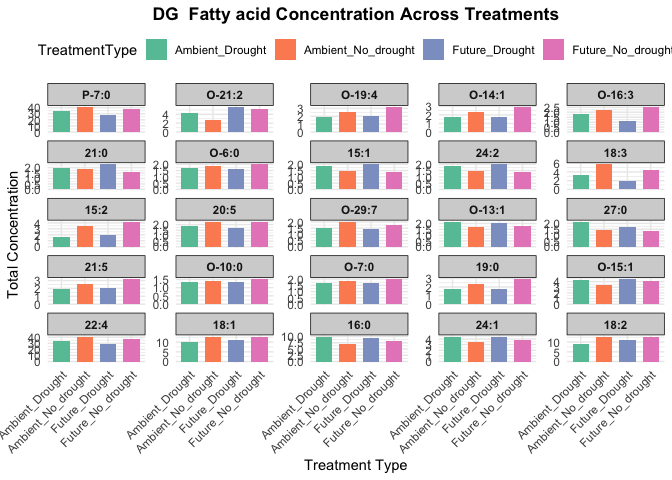

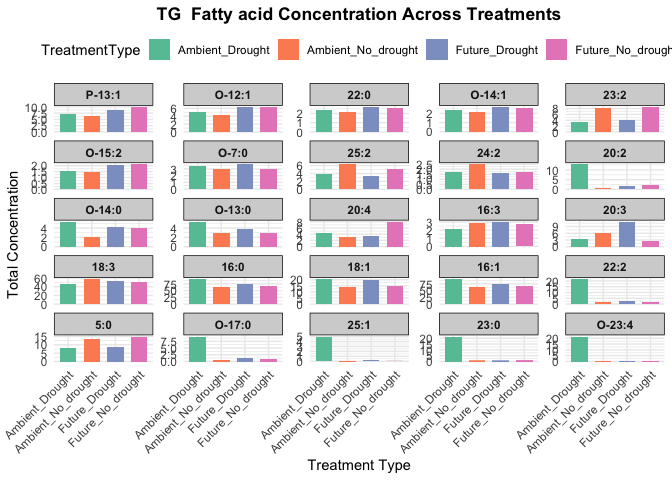

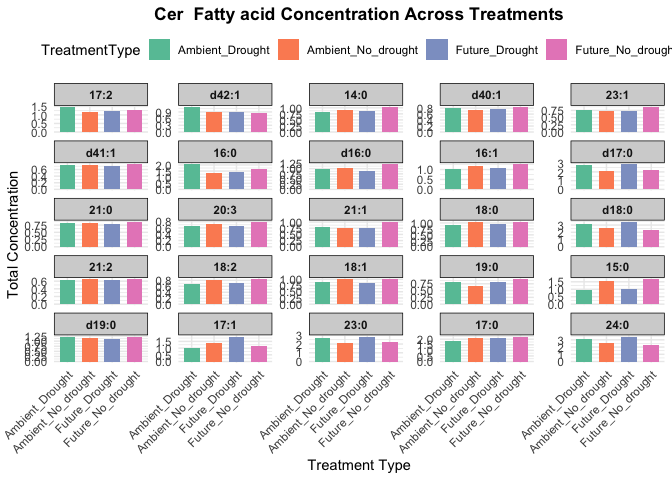

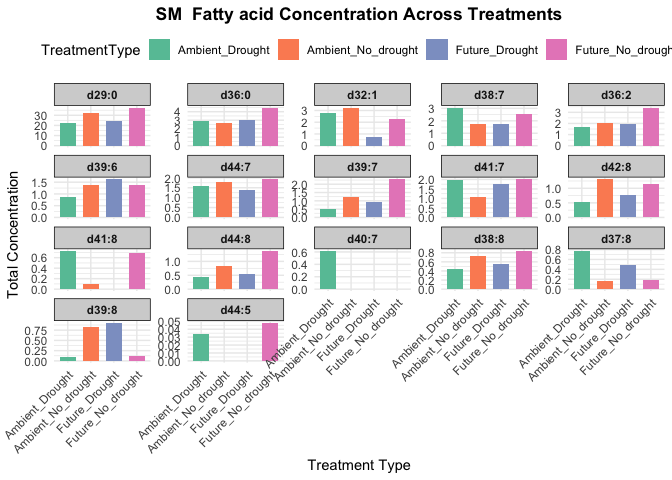

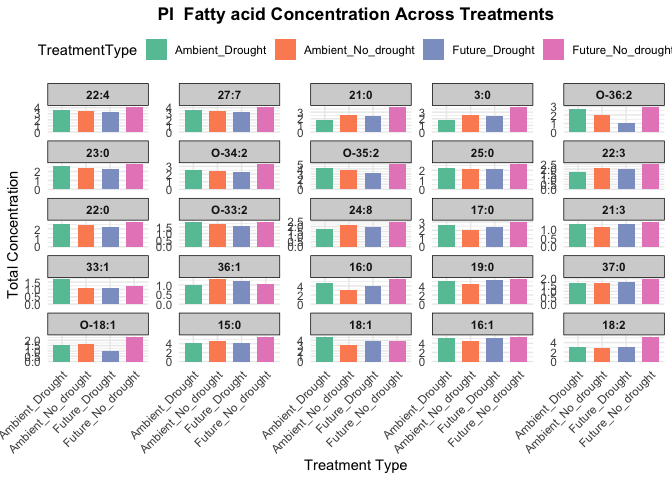

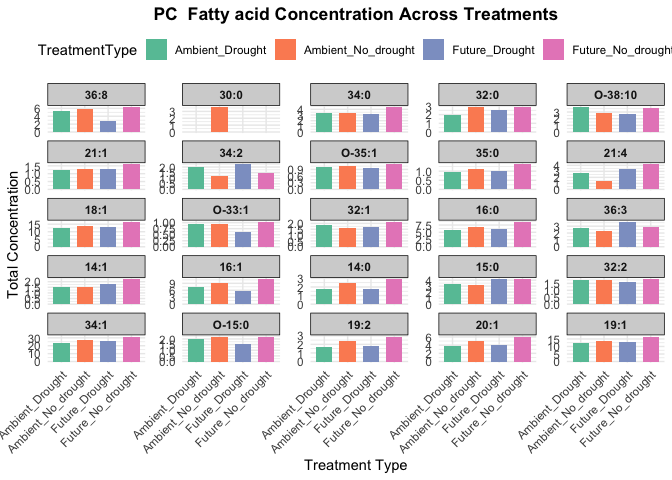

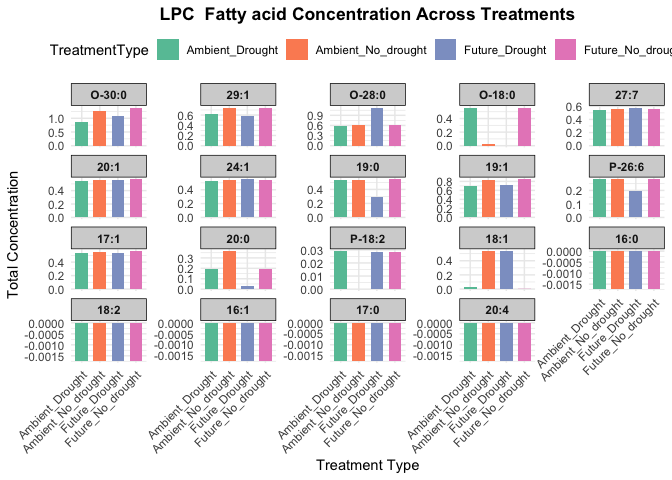

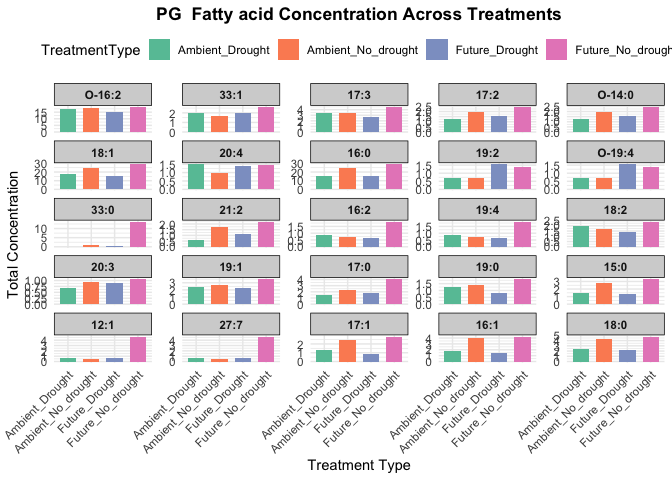

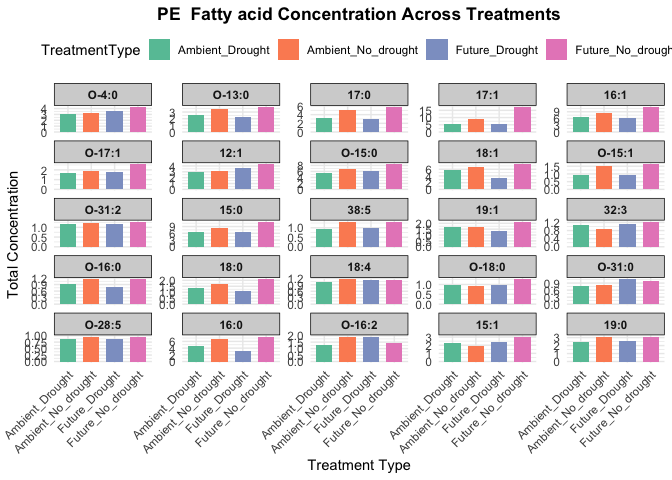

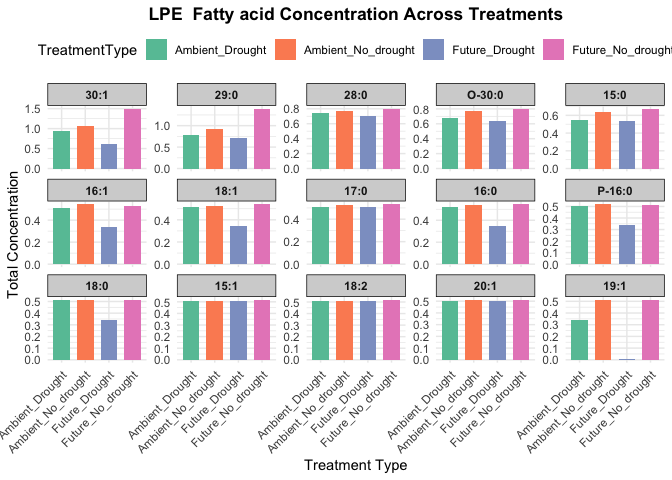

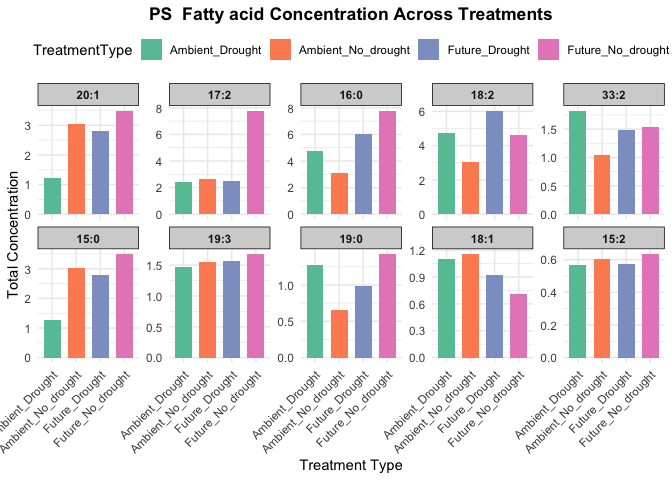

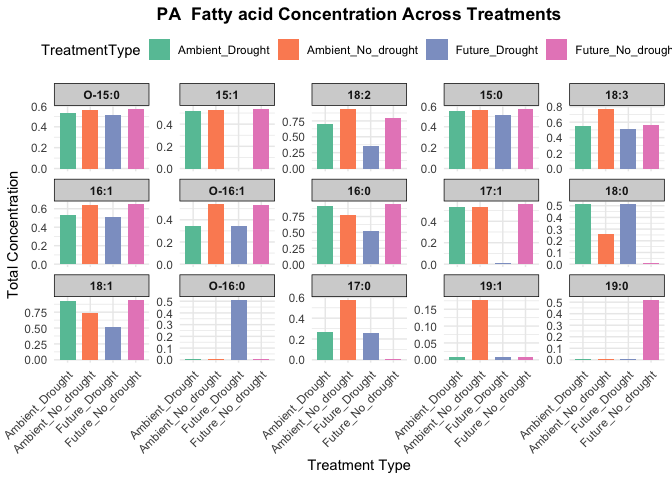

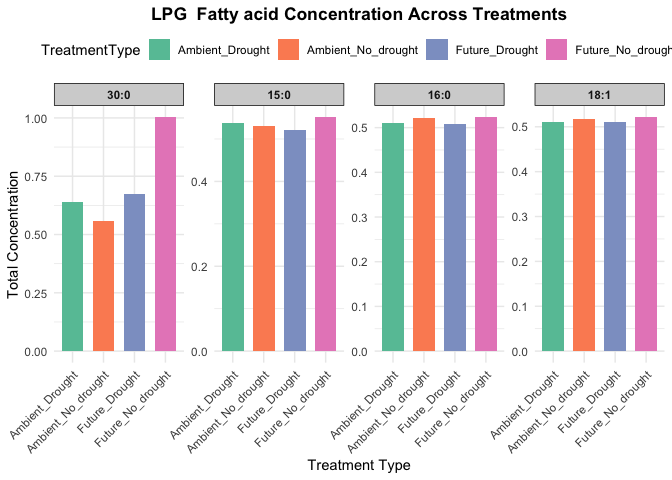

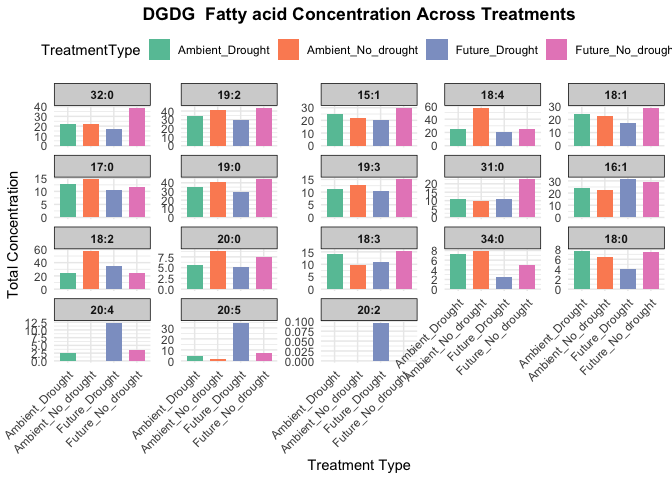

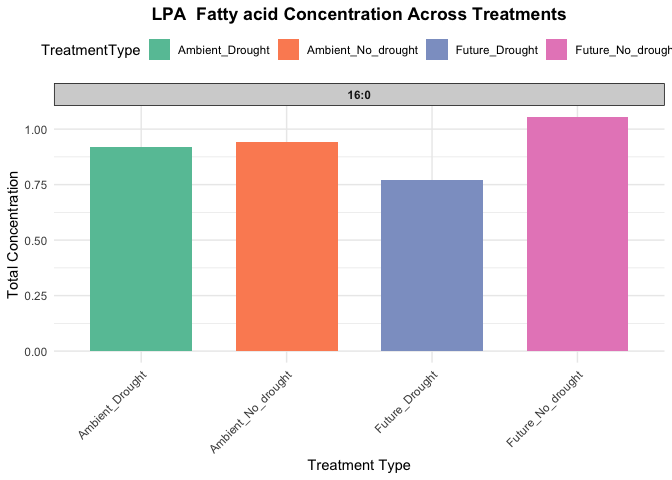

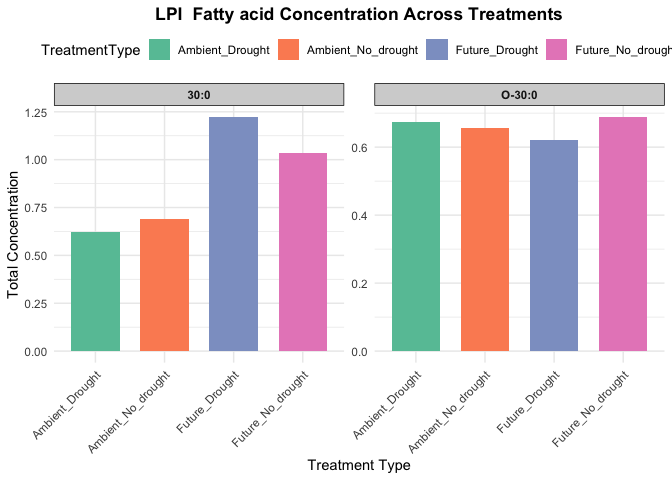

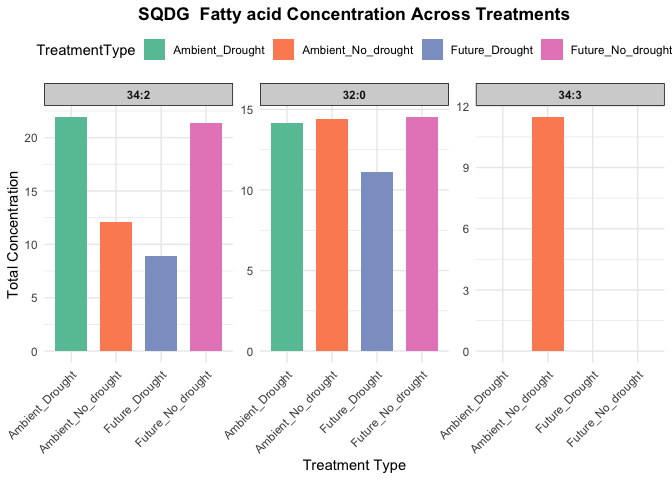

In [ ]:
process_molecule_list <- function(molecule) {
  # Filter the dataframe for the current Molecule List
  current_df <- merged_df %>% filter(`Molecule List` == molecule)
  
  # Define the concentration columns based on the correct naming convention
  concentration_columns <- grep('Sum Total Area Concentration', colnames(current_df), value = TRUE)
  
  # Function to create a summarized dataframe for a specific treatment
  create_summary_df <- function(samples, treatment_name) {
    concentration_cols <- grep(paste(samples, collapse = "|"), concentration_columns, value = TRUE)
    df <- current_df %>% select(FAKey_Part, all_of(concentration_cols))
    df <- df %>%
      rowwise() %>%
      mutate(mean_concentration = mean(c_across(all_of(concentration_cols)), na.rm = TRUE),
             std_concentration = sd(c_across(all_of(concentration_cols)), na.rm = TRUE)) %>%
      ungroup()
    df$TreatmentType <- treatment_name
    return(df)
  }
  
  # Create summarized dataframes for each treatment
  ambient_no_drought_df <- create_summary_df(c('19', '22', '36'), 'Ambient_No_drought')
  future_no_drought_df <- create_summary_df(c('35', '40', '52'), 'Future_No_drought')
  ambient_drought_df <- create_summary_df(c('28', '44', '49'), 'Ambient_Drought')
  future_drought_df <- create_summary_df(c('27', '43', '48'), 'Future_Drought')
  
  # Combine all the summarized dataframes
  combined_df <- bind_rows(ambient_no_drought_df, future_no_drought_df, ambient_drought_df, future_drought_df)
  
  # Remove rows with NA mean_concentration
  combined_df <- combined_df %>% filter(!is.na(mean_concentration))
  
  # Check if there's any data left to plot
  if(nrow(combined_df) == 0) {
    warning(paste("No valid data for molecule:", molecule))
    return(NULL)
  }
  
  # Select top 25 fatty acids by mean concentration
  top_25_fa <- combined_df %>%
    group_by(FAKey_Part) %>%
    summarize(mean_conc = mean(mean_concentration, na.rm = TRUE)) %>%
    top_n(25, mean_conc) %>%
    pull(FAKey_Part)
  
  # Filter data for top 25 fatty acids
  plot_data <- combined_df %>%
    filter(FAKey_Part %in% top_25_fa) %>%
    mutate(FAKey_Part = fct_reorder(FAKey_Part, mean_concentration, .desc = TRUE))
  
  # Create the plot
  p <- ggplot(plot_data, aes(x = TreatmentType, y = mean_concentration, fill = TreatmentType)) +
    geom_bar(stat = 'identity', position = position_dodge(), width = 0.7) +
    #geom_errorbar(aes(ymin = pmax(mean_concentration - std_concentration, 0), 
     #                 ymax = mean_concentration + std_concentration),
      #            position = position_dodge(0.7), width = 0.25) +
    facet_wrap(~ FAKey_Part, scales = "free_y", ncol = 5) +
    scale_fill_brewer(palette = "Set2") +
    labs(title = paste(molecule, ' Fatty acid Concentration Across Treatments'),
         x = 'Treatment Type', 
         y = 'Total Concentration',
         ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "top",
      strip.background = element_rect(fill = "lightgrey"),
      strip.text = element_text(face = "bold"),
      plot.title = element_text(hjust = 0.5, face = "bold")
    )
  
  print(p)
  
  # Save the plot
  ggsave(paste0(molecule, "_comparison_by_fatty_acid.pdf"), plot = p, width = 15, height = 12)
  
  # Return the combined dataframe
  return(combined_df)
}

# Get all unique Molecule List values
molecule_lists <- unique(merged_df$`Molecule List`)

# Process all Molecule Lists
results <- map(molecule_lists, safely(process_molecule_list))